**Importing Dependencies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm   ## used for creating progress bars

#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
#from tf.keras.applications.resnet50.ResNet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.layers.wrappers import Bidirectional
from keras.regularizers import l2
from keras import layers

**Loading dataset**

In [3]:
#dataset = '/content/drive/MyDrive/main_project/image_dataset'
#orginal_path = '/content/drive/MyDrive/main_project'
#testing_path = '/content/drive/MyDrive/main_project/test_images'

dataset = '/content/drive/MyDrive/project/sample_project/image_dataset'
orginal_path = '/content/drive/MyDrive/project/sample_project'


**Loading CNN model --> VGG-16**

In [4]:
# load vgg16 model
#model = VGG16()
# restructure the model
#model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model = tf.keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet',input_shape=None,pooling='avg')
# summarize
print(model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [13]:
# extract features from image
features = {}
directory = os.path.join(dataset,'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = tf.keras.applications.resnet50.preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [14]:
# store features in pickle
pickle.dump(features, open(os.path.join(orginal_path, 'extracted_new.pkl'), 'wb'))

In [5]:
# load features from pickle
with open(os.path.join(orginal_path, 'extracted_new.pkl'), 'rb') as f:
    features = pickle.load(f)

**Load the Captions Data**

In [6]:
with open(os.path.join(dataset, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

**Pre-Processing Caption**


In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1009434119_febe49276a']

['A black and white dog is running in a grassy garden surrounded by a white fence .',
 'A black and white dog is running through the grass .',
 'A Boston terrier is running in the grass .',
 'A Boston Terrier is running on lush green grass in front of a white fence .',
 'A dog runs on the green grass near a wooden fence .']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['1009434119_febe49276a']

['startseq black and white dog is running in grassy garden surrounded by white fence endseq',
 'startseq black and white dog is running through the grass endseq',
 'startseq boston terrier is running in the grass endseq',
 'startseq boston terrier is running on lush green grass in front of white fence endseq',
 'startseq dog runs on the green grass near wooden fence endseq']

In [14]:
all_captions = [] # a list named all_captions is created which contain all the captions.
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
#to store the tokenizer
pickle.dump(tokenizer, open(os.path.join(orginal_path, 'tokenizer_1.pkl'), 'wb'))

In [19]:
vocab_size

8485

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length


35

**Train Test Split**

In [21]:
image_ids = list(mapping.keys())
print(len(image_ids))

8091


In [22]:
split = int(len(image_ids) * 0.90)  
print(split)

7281


In [23]:
train = image_ids[:split] # 90% of the images are used for training purpose
test = image_ids[split:]  # remaining 10% for the testing purpose

In [24]:
# startseq girl going into wooden building endseq
#    X (text sequence)             y(word to be predicted)
#      startseq                             girl
#      startseq girl                        going
#      startseq girl going                  into
# ...........
# startseq girl going into wooden building      endseq

In [25]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0  # iteration variable for batch_size
    while 1:
        for key in data_keys: # data_keys indicates the  image ids used for training
            n += 1
            captions = mapping[key] # 'captions' variable stores 5 captions of each image at a time
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0] # pads sequences to same length
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] 
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y # yield function is used instead of return that will outputs a generator
                X1, X2, y = list(), list(), list() 
                n = 0

**Model Creation**

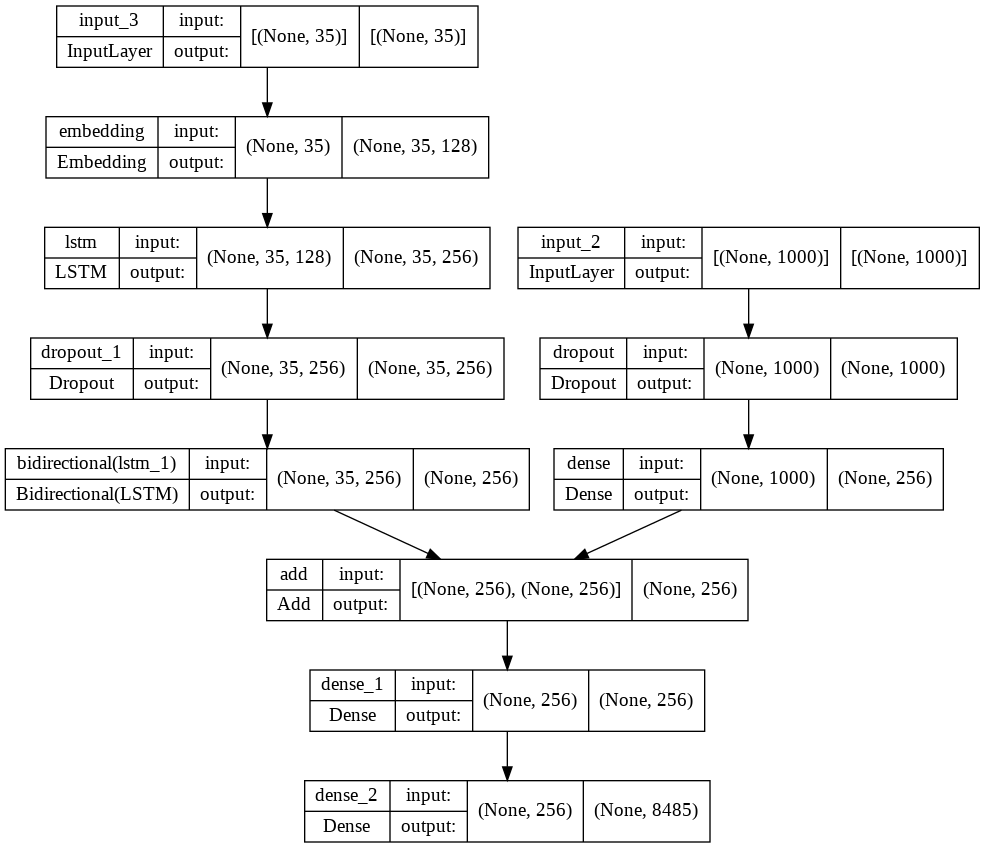

In [26]:
# encoder model
# image feature layers
inputs1 = Input(shape=(1000,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 128, mask_zero=True)(inputs2)
se2 = LSTM(256,return_sequences=True,recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))(se1)
se3 = Dropout(0.5)(se2)
se4 = Bidirectional(LSTM(128,recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(se3)

# decoder model
decoder1 = add([fe2, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


In [27]:
# train the model
from tensorflow.keras.callbacks import TensorBoard
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)
epochs = 25
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[tb_callback])

113/113 [==============================] - 67s 592ms/step - loss: 3.0114 - categorical_accuracy: 0.3408


In [28]:
# save the model
model.save(orginal_path+'/new_best_model.h5')

**Generate Caption for the Image**

In [29]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

**generate caption for an image**

In [30]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [31]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smoothie))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.516616
BLEU-2: 0.282731


**Visualize the Results**

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(dataset, "Images", image_name)
    image = Image.open(img_path)
    #if (image_id, value) in mapping.items() :
     # captions = mapping[image_id]
     # print('---------------------Actual---------------------')
     # for caption in captions:
     #   print(caption)
    #else :
      #print(" No actual caption ")
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

--------------------Predicted--------------------
startseq two dogs are playing in the grass endseq


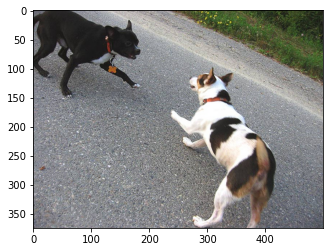

In [33]:
generate_caption("1001773457_577c3a7d70.jpg")

--------------------Predicted--------------------
startseq young girl in pink dress is standing in front of brick building endseq


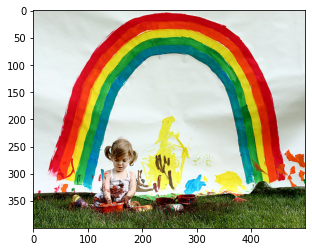

In [34]:
generate_caption("1002674143_1b742ab4b8.jpg")

--------------------Predicted--------------------
startseq man in red shirt is riding his skateboard endseq


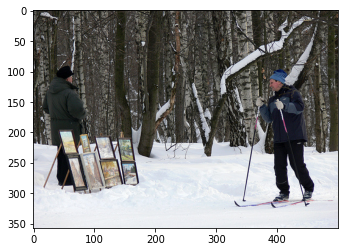

In [35]:
generate_caption("101669240_b2d3e7f17b.jpg")

--------------------Predicted--------------------
startseq brown dog is running through the water endseq


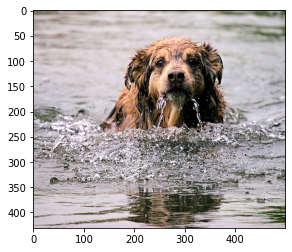

In [37]:
generate_caption("262642489_f5c6b9e65b.jpg")

--------------------Predicted--------------------
startseq woman in pink shirt and woman in black dress endseq


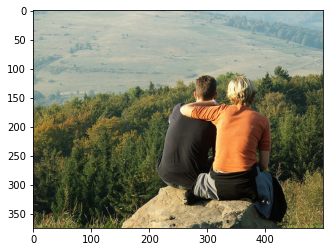

In [38]:
generate_caption("263216826_acf868049c.jpg")

--------------------Predicted--------------------
startseq the white and white dog is running through the snow endseq


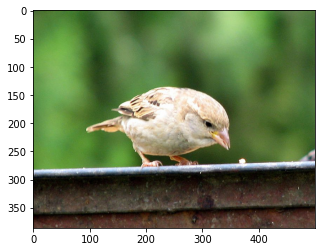

In [43]:
generate_caption("308487515_7852928f90.jpg")